In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import pandas as pd
import vectorbt as vbt
from core.data_loader import DataLoader
import os
import sys
from core.backtester import Backtester
from strategies.atr_breakout import ATRTrailingBreakout
from strategies.multi_momentum import MultiTimeframeMomentum
from strategies.vwap_reversion import VWAPReversion
from strategies.bb_rsi import BB_RSI
import logging
from datetime import datetime
import pandas as pd
import numpy as np
import pandas as pd
import vectorbt as vbt
import yfinance as yf
from matplotlib import pyplot as plt

In [2]:
# Налаштування логування
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Завантаження даних
loader = DataLoader()
data_file = 'vet_1h_mrhapr25_askbid.parquet'
if os.path.exists(os.path.join('data', data_file)):
    logger.info("Завантаження даних...")
    # dfh = loader.fetch_historical_bid_ask('VETBTC', '1h', start_date='2025-03-01', end_date='2025-05-01')
    
    end_date = (datetime.now() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    start_date = (datetime.now() - pd.DateOffset(months=2)).strftime('%Y-%m-%d')
    df = loader.fetch_historical_bid_ask('VETBTC', '1h', start_date=start_date, end_date=end_date)
    loader.save_data({'VETBTC': df}, data_file)
else:
    df = loader.load_data(data_file, '1h')
    df = df['VETBTC']
data = df['close']
symbol = 'VETBTC'
df
split_point = len(df) // 2
test_df = df.iloc[split_point:]
df = df.iloc[:split_point]
test_df

INFO:__main__:Завантаження даних...


,open,high,low,close,volume,bid,ask
timestamp,,,,,,,
2025-03-19 21:00:00,3.100000e-07,3.200000e-07,3.000000e-07,3.200000e-07,2248792.0,3.100000e-07,3.300000e-07
2025-03-19 22:00:00,3.200000e-07,3.200000e-07,3.100000e-07,3.200000e-07,165654.0,3.100000e-07,3.300000e-07
2025-03-19 23:00:00,3.100000e-07,3.200000e-07,3.000000e-07,3.100000e-07,1408168.0,3.000000e-07,3.200000e-07
2025-03-20 00:00:00,3.200000e-07,3.200000e-07,3.100000e-07,3.100000e-07,303961.0,3.000000e-07,3.200000e-07
2025-03-20 01:00:00,3.100000e-07,3.200000e-07,3.100000e-07,3.200000e-07,291834.0,3.100000e-07,3.300000e-07
...,...,...,...,...,...,...,...
2025-04-18 14:00:00,2.800000e-07,2.800000e-07,2.700000e-07,2.700000e-07,18415.0,2.600000e-07,2.800000e-07
2025-04-18 15:00:00,2.800000e-07,2.800000e-07,2.700000e-07,2.700000e-07,16413.0,2.600000e-07,2.800000e-07
2025-04-18 16:00:00,2.800000e-07,2.800000e-07,2.800000e-07,2.800000e-07,27667.0,2.700000e-07,2.900000e-07


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf  # Optional - for fetching data

def calculate_bollinger_bands(data, window=20, num_std=2):
    """
    Calculate Bollinger Bands with forward shift to avoid look-ahead bias.
    
    Parameters:
    - data: Pandas Series of closing prices
    - window: Moving average window (typically 20)
    - num_std: Number of standard deviations for the bands (typically 2)
    
    Returns:
    - DataFrame with columns: Middle Band, Upper Band, Lower Band
    """
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    
    # Shift all bands forward by 1 to avoid look-ahead bias
    return pd.DataFrame({
        'Middle Band': rolling_mean.shift(1),
        'Upper Band': upper_band.shift(1),
        'Lower Band': lower_band.shift(1)
    })

def keep_last_true_in_sequence(series):
    """
    Process a boolean Series to keep only the last True in each uninterrupted sequence.
    
    Args:
        series: pandas Series of boolean values
        
    Returns:
        A new Series with only the last True from each True sequence
    """
    # Initialize the result Series with all False
    result = pd.Series(False, index=series.index)
    
    # Find the boundaries of True sequences
    shifted = series.shift(1, fill_value=False)
    starts = series & ~shifted  # First True in sequence
    ends = series & ~series.shift(-1, fill_value=False)  # Last True in sequence
    
    # Keep only the last True in each sequence
    result[ends] = True
    
    return result

def identify_crossovers(close_prices, bb_df):
    """
    Identify where price crosses Bollinger Bands.
    
    Returns:
    - DataFrame with crossover signals:
      - 'Upper Cross': Price crosses above upper band
      - 'Lower Cross': Price crosses below lower band
    """
    signals = pd.DataFrame(index=close_prices.index)
    signals['Upper Cross'] = (close_prices > bb_df['Upper Band'])
    signals['Lower Cross'] = (close_prices < bb_df['Lower Band'])
    return signals 

def generate_trading_signals(close_prices, bb_df, signals):
    """
    Generate a DataFrame with clear trading signals and positions.
    """
    trades = pd.DataFrame(index=close_prices.index)
    trades['Price'] = close_prices
    trades = trades.join(bb_df).join(signals)
    
    # Initialize position column
    trades['Position'] = 0
    
    # Generate signals (1 for long, -1 for short)
    trades.loc[trades['Lower Cross'], 'Position'] = 1
    trades.loc[trades['Upper Cross'], 'Position'] = -1
    
    return trades

def plot_bollinger_bands_with_signals(data, bb_df, signals, symbol=''):
    """
    Enhanced plot showing:
    - Price and Bollinger Bands
    - Crossover points
    - Fill between bands
    """
    plt.figure(figsize=(14, 7))
    
    # Plot price and bands
    plt.plot(data.index, data, label='Close Price', color='blue', alpha=0.7, linewidth=1.5)
    plt.plot(bb_df.index, bb_df['Middle Band'], label='Middle Band (SMA)', color='red', linestyle='--')
    plt.plot(bb_df.index, bb_df['Upper Band'], label='Upper Band', color='green', linestyle='-')
    plt.plot(bb_df.index, bb_df['Lower Band'], label='Lower Band', color='green', linestyle='-')
    
    # Fill between bands
    plt.fill_between(bb_df.index, bb_df['Upper Band'], bb_df['Lower Band'], color='gray', alpha=0.1)
    
    # Plot crossover signals
    upper_crosses = signals[signals['Upper Cross']].index
    lower_crosses = signals[signals['Lower Cross']].index
    
    plt.scatter(upper_crosses, data[upper_crosses], 
               color='red', marker='v', s=100, label='Upper Band Cross (Sell Signal)')
    plt.scatter(lower_crosses, data[lower_crosses], 
               color='green', marker='^', s=100, label='Lower Band Cross (Buy Signal)')
    
    plt.title(f'Bollinger Bands with Trading Signals - {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
def bb_strategy_tester(df, window=20, std_dev=2.0, delta=0.01):
    """
    Enhanced Bollinger Bands strategy that:
    1. Triggers when price ENTERS bands (not breaks through)
    2. Uses special price calculation formula
    3. Provides detailed trade statistics
    
    Args:
        df: DataFrame with columns ['open', 'high', 'low', 'close', 'volume']
        window: BB window size
        std_dev: BB standard deviation multiplier
    
    Returns:
        Tuple of (portfolio, cross_stats)
    """
    # Calculate Bollinger Bands
    df['hl_avg'] = (df['high'] + df['low']) / 2
    bb = vbt.BBANDS.run(df['hl_avg'], window=window, alpha=std_dev)
    
    # Initialize signals and price trackers
    entries = pd.Series(False, index=df.index)
    exits = pd.Series(False, index=df.index)
    prices = pd.Series(np.nan, index=df.index)

    pers = 0.00000001
    
    for i in range(1, len(df)):
        prev_high = df['high'].iloc[i-1]
        prev_low = df['low'].iloc[i-1]
        current_low = df['low'].iloc[i]
        current_high = df['high'].iloc[i]
        current_close = df['close'].iloc[i]
        lower_band = np.round(bb.lower.shift(1).iloc[i] + pers/2, decimals=8)
        upper_band = np.round(bb.upper.shift(1).iloc[i] - pers/2, decimals=8)

        if (upper_band - lower_band) / lower_band < delta:
            continue

        # Buy signal: Price enters lower band (from above)
        if (current_low + pers < lower_band):
            entries.iloc[i] = True
            prices.iloc[i] = lower_band  # Use band price

        # Sell signal: Price enters upper band (from below)
        if (current_high - pers > upper_band):
            exits.iloc[i] = True
            prices.iloc[i] = upper_band  # Use band price
        
        # # Buy signal: Price enters lower band (from above)
        # if (
        #     # (last_sell_price > lower_band * (1 + pers)) and
        #     (prev_low < lower_band) and (current_high > lower_band)):
        #     entries.iloc[i] = True
        #     prices.iloc[i] = lower_band  # Use band price
        #     last_buy_price = lower_band

        # # Sell signal: Price enters upper band (from below)
        # if (
        #     # (last_buy_price < upper_band * 1 - pers) and
        #     (prev_high > upper_band) and (current_low < upper_band)):
        #     exits.iloc[i] = True
        #     prices.iloc[i] = upper_band  # Use band price
        #     last_sell_price = upper_band

    # Create portfolio using actual execution prices
    pf = vbt.Portfolio.from_signals(
        close=df['close'],
        entries=entries,
        exits=exits,
        price=prices.fillna(df['close']),
        fees=0.001,  # 0.1% fee per trade
        # slippage=0.001,  # 0.1% slippage per trade
        freq='1h'
    )
    
    return pf

# Example usage:
# Load your data
# df = pd.read_csv('your_data.csv', parse_dates=['date'], index_col='date')
results = bb_strategy_tester(df, window=20, std_dev=2)
print(results.stats()['Total Return [%]'])
results.plot()


-6.622555078658024


FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'bf1963f1-56eb-41e7-846f-ecf3abd6325f',
              'x': array([datetime.datetime(2025, 2, 18, 0, 0),
                          datetime.datetime(2025, 2, 18, 1, 0),
                          datetime.datetime(2025, 2, 18, 2, 0), ...,
                          datetime.datetime(2025, 3, 19, 18, 0),
                          datetime.datetime(2025, 3, 19, 19, 0),
                          datetime.datetime(2025, 3, 19, 20, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([3.4e-07, 3.4e-07, 3.5e-07, ..., 3.2e-07, 3.1e-07, 3.1e-07]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 3.02727575e+08, 9.99000999e-02],
                                   [2.00000000e+00, 2.92681390e+08, 9.36580448e-02],
                          

/home/roman/Desktop/binance_ai/.venv/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




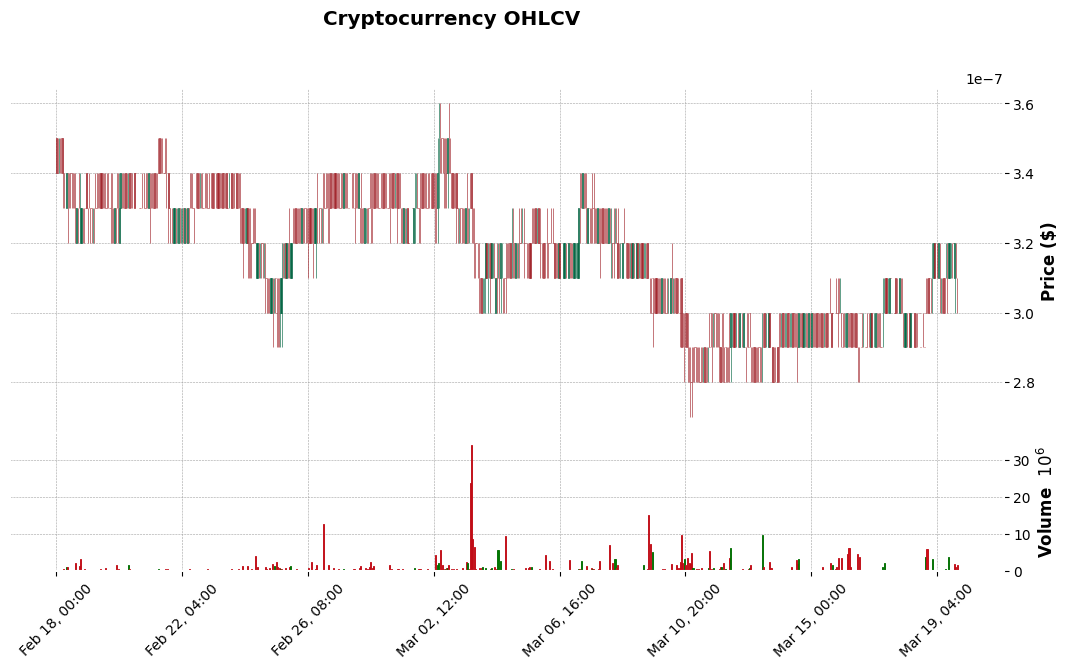

In [5]:
import pandas as pd
import mplfinance as mpf

# Create candlestick plot
mpf.plot(df, 
         type='candle',
         style='charles',
         title='Cryptocurrency OHLCV',
         ylabel='Price ($)',
         volume=True,  # Show volume bars
         figratio=(12, 6),
         figscale=1.2)

In [6]:
def optimize_bollinger_bands(df, window_range, std_range, delta_range):
    results = []
    total_combinations = len(window_range) * len(std_range) * len(delta_range)
    progress_bar = tqdm(total=total_combinations, desc="Optimizing parameters")
    
    for params in [(w, s, d) for w in window_range for s in std_range for d in delta_range]:
        window, std, delta = params
        
        pf = bb_strategy_tester(df, window, std, delta)
        
        # Store results
        stats = pf.stats()
        results.append({
            'window': window,
            'std': std,
            'delta': delta,
            'total_return': stats['Total Return [%]'],
            'sharpe_ratio': stats['Sharpe Ratio'],
            'win_rate': stats['Win Rate [%]'],
            'profit_factor': stats['Profit Factor'],
            'trades': stats['Total Trades'],
            'portfolio': pf
        })
        
        progress_bar.update(1)
    
    progress_bar.close()
    results_df = pd.DataFrame(results)
    
    best_idx = results_df['total_return'].idxmax()
    best_window = results_df.loc[best_idx, 'window']
    best_std = results_df.loc[best_idx, 'std']
    best_delta = results_df.loc[best_idx, 'delta']
    best_pf = results_df.loc[best_idx, 'portfolio']
    
    return best_window, best_std, best_delta, results_df, best_pf


In [7]:

# Parameter ranges to test
window_range = range(2, 56, 1)  # From 10 to 50 in steps of 5
std_range = np.arange(0, 5, .5)  # From 1.5 to 3.0 in steps of 0.25
delta_range = np.arange(0, 0.09, 0.02)  # From 0.5 to 1.5 in steps of 0.1

# Run optimization
best_window, best_std, best_delta, results_df, best_pf = optimize_bollinger_bands(
    df, window_range, std_range, delta_range
)

print(f"\nOptimal Parameters - Window: {best_window}, Std: {best_std:.2f}, Delta: {best_delta:.4f}")
print("\nPerformance Metrics with Optimal Parameters:")
print(best_pf.stats())


Optimizing parameters: 100%|██████████| 2700/2700 [16:03<00:00,  2.80it/s]


Optimal Parameters - Window: 5, Std: 2.50, Delta: 0.0200

Performance Metrics with Optimal Parameters:
Start                         2025-02-18 00:00:00
End                           2025-03-19 20:00:00
Period                           29 days 21:00:00
Start Value                                 100.0
End Value                              109.805984
Total Return [%]                         9.805984
Benchmark Return [%]                    -8.823529
Max Gross Exposure [%]                      100.0
Total Fees Paid                          0.305549
Max Drawdown [%]                        12.209003
Max Drawdown Duration             8 days 23:00:00
Total Trades                                    2
Total Closed Trades                             1
Total Open Trades                               1
Open Trade PnL                           6.981535
Win Rate [%]                                100.0
Best Trade [%]                           2.827273
Worst Trade [%]                          2.827

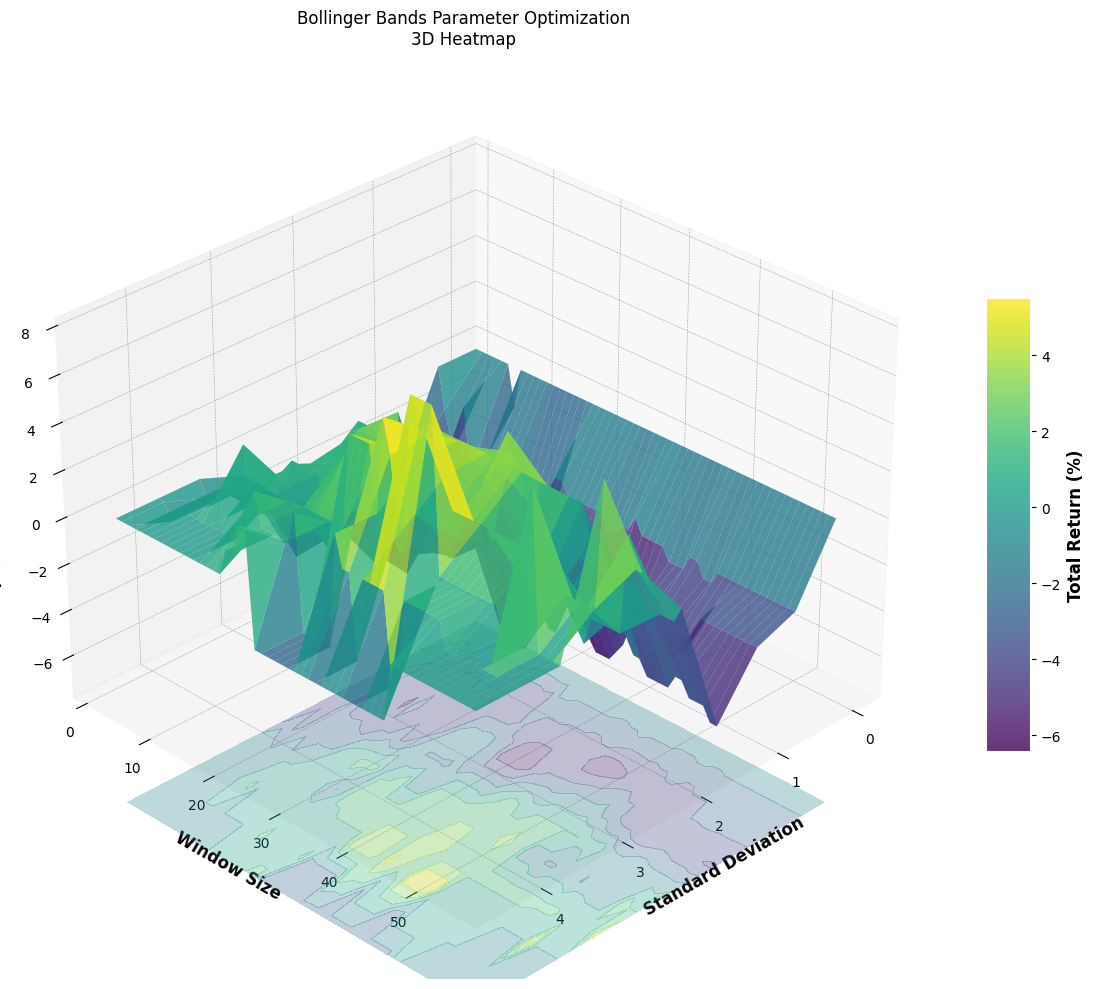

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plot_3d_heatmap(results_df):
    """
    Create interactive 3D heatmap of optimization results
    Args:
        results_df: DataFrame with columns ['window', 'std', 'delta', 'total_return']
    """
    # Create pivot table
    pivot_table = results_df.pivot_table(index='window', 
                                       columns='std', 
                                       values='total_return',
                                       aggfunc='mean')
    
    # Prepare data for 3D plot
    X = pivot_table.columns.values  # std values
    Y = pivot_table.index.values    # window values
    X, Y = np.meshgrid(X, Y)
    Z = pivot_table.values
    
    # Create figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot surface
    surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis,
                          rstride=1, cstride=1,
                          alpha=0.8, linewidth=0.2,
                          antialiased=True)
    
    # Add contour projection
    ax.contourf(X, Y, Z, zdir='z', offset=Z.min()-5, cmap=cm.viridis, alpha=0.3)
    
    # Customize axes
    ax.set_xlabel('Standard Deviation', labelpad=10)
    ax.set_ylabel('Window Size', labelpad=10)
    ax.set_zlabel('Total Return (%)', labelpad=10)
    ax.set_title('Bollinger Bands Parameter Optimization\n3D Heatmap', pad=20)
    
    # Add colorbar
    fig.colorbar(surf, shrink=0.5, aspect=10, label='Total Return (%)')
    
    # Rotate for better view
    ax.view_init(elev=30, azim=45)
    
    plt.tight_layout()
    plt.show()
    
plot_3d_heatmap(results_df)

In [9]:
best_pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '0cfaa3f7-8d70-465b-8e38-532de2763c21',
              'x': array([datetime.datetime(2025, 2, 18, 0, 0),
                          datetime.datetime(2025, 2, 18, 1, 0),
                          datetime.datetime(2025, 2, 18, 2, 0), ...,
                          datetime.datetime(2025, 3, 19, 18, 0),
                          datetime.datetime(2025, 3, 19, 19, 0),
                          datetime.datetime(2025, 3, 19, 20, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([3.4e-07, 3.4e-07, 3.5e-07, ..., 3.2e-07, 3.1e-07, 3.1e-07]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 3.02727575e+08, 9.99000999e-02],
                                   [2.00000000e+00, 3.54212850e+08, 1.02721727e-01]]),
              'hovertemp

In [10]:
bb_strategy_tester(test_df,best_window,best_std,best_delta).stats()['Total Return [%]']

np.float64(11.776223776223816)

In [11]:
bb_strategy_tester(test_df,best_window,best_std).plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'b377640d-9e65-495d-aeeb-d434f7e8d82a',
              'x': array([datetime.datetime(2025, 3, 19, 21, 0),
                          datetime.datetime(2025, 3, 19, 22, 0),
                          datetime.datetime(2025, 3, 19, 23, 0), ...,
                          datetime.datetime(2025, 4, 18, 16, 0),
                          datetime.datetime(2025, 4, 18, 17, 0),
                          datetime.datetime(2025, 4, 18, 18, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([3.2e-07, 3.2e-07, 3.1e-07, ..., 2.8e-07, 2.8e-07, 2.8e-07]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 3.99600400e+08, 9.99000999e-02]]),
              'hovertemplate': ('Order Id: %{customdata[0]}<br>' ... '<br>Fees: %{customdata[2]:.6f}'),
  

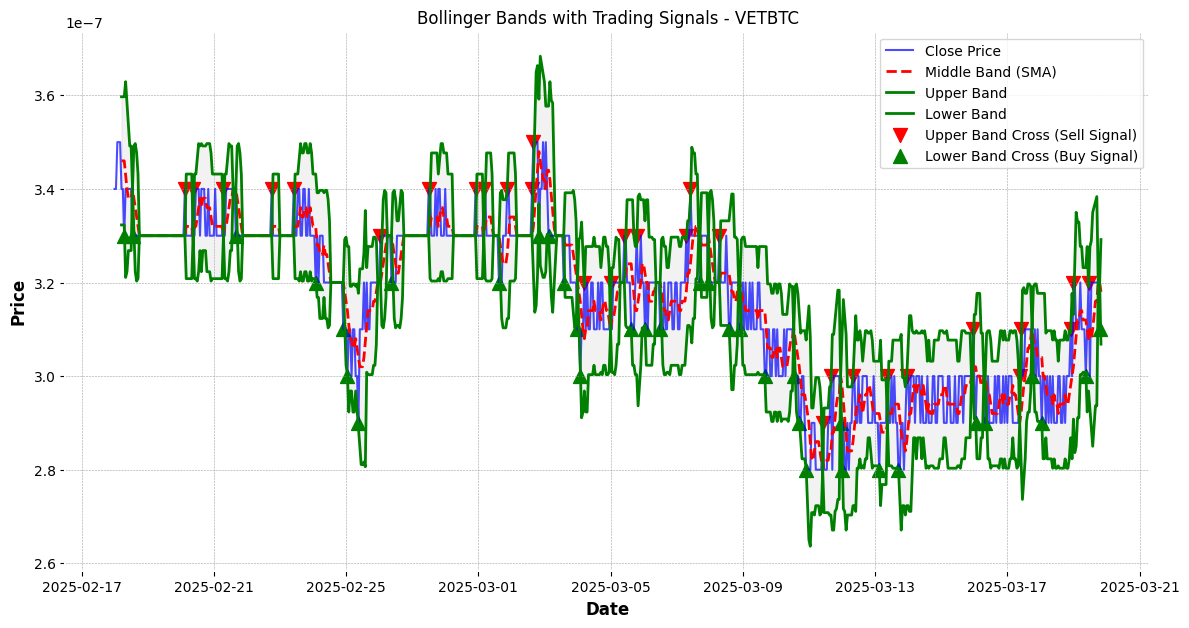

In [12]:
bb_df = calculate_bollinger_bands(df['close'], best_window, best_std)
signals = identify_crossovers(df['close'], bb_df)
trades = generate_trading_signals(df['close'], bb_df, signals)

# Print some trading signals
# print("Sample Trading Signals:")
# print(trades[trades['Position'] != 0].head(10))

# Plot with signals
plot_bollinger_bands_with_signals(df['close'], bb_df, signals, symbol)